In [34]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import pandas as pd 
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime

from split_filename import *
from GOLD import *


class GOLD:
    
    def __init__(self, filename, infile = None):
        
        self.infile = infile 
        self.filename = filename
    
        if isinstance(filename, xr.Dataset):
            self.dataset = filename 
        else:
            self.dataset = xr.open_dataset(self.infile + self.filename)
            file_args = split_filename(self.filename)
        
            if file_args.product == 'LIM':
                self.dims = ['n_lat', 'n_alt']

                self.dataset.coords['n_alt'] = self.dataset['GRID_ALT'].values
                self.dataset.coords['n_lat'] = self.dataset['GRID_LAT'].values

            elif file_args.product == 'OCC':

                self.dataset.coords['n_wavelength'] = self.dataset['WAVELENGTH'].values[0]
                self.dataset.coords['nTimes'] = bytes_string(self.dataset['TIME_UTC'])
                

            else:
                self.dims = ['n_ns', 'n_ew']

                self.dataset.coords['n_wavelength'] = self.dataset['WAVELENGTH'].mean(dim = self.dims)
    
    def dataset(self):
        return self.dataset
        
    
    def get_1356(self):
        """
        1356 brightness map (in Rayleighs) integrates the signal from 133 to 137 nm
        """
        arr = self.dataset['n_wavelength'].values
        
        cond = (arr > 133) & (arr < 137)
        
        result_1356 = np.where(cond, arr, np.nan)
        
        result_1356 = result_1356[~np.isnan(result_1356)]

        return self.dataset.sel(n_wavelength = result_1356)

    
    def get_LBH(self, band = 'total'):
        """
        Individual files:
            Total LBH brightness map (in Rayleighs) integrates the signal from 137 to 155 nm
            with 148.5 to 150.0 nm masked;
        Combined files:
            LBH band 1 brightness map (in Rayleighs) integrates the signal from 140 to 148 nm; 
            LBH band 2 brightness map (in Rayleighs) integrates the signal from 150 to 160 nm. 
        """
        wavelength_values = self.dataset['n_wavelength'].values
        
        if band == 'total':
            start, end = 137, 155
        elif band == 1:
            start, end = 140, 148
        else:
            start, end = 150, 160
        
        cond = (wavelength_values > start) & (wavelength_values < end)
        
        result_LHB = np.where(cond, wavelength_values, np.nan)
        
        result_LHB = result_LHB[~np.isnan(result_LHB)]

        return self.dataset.sel(n_wavelength = result_LHB)

In [3]:
infile = 'C:\\Users\\Luiz Felipe\\Downloads\\TLIMB2019111120191112\\tmp\\archive_L2\\2019\\315\\'

filename = 'GOLD_L2_TLIMB_2019_315_v03_r01_c01.nc'

ds = xr.open_dataset(infile + filename)

ds

<xarray.Dataset>
Dimensions:                           (nlats: 32, nlons: 30, nmask: 4001, nscans: 50)
Dimensions without coordinates: nlats, nlons, nmask, nscans
Data variables:
    tlimb_unc_mod                     (nscans, nlats) float32 ...
    n2_lbh_unc_ran                    (nscans, nlats, nlons) float64 ...
    n2_scale_height_unc_ran           (nscans, nlats) float32 ...
    tlimb                             (nscans, nlats) float32 ...
    mask_wavelength                   (nmask) float32 ...
    channel                           (nscans) |S50 ...
    tlimb_dqi                         (nscans, nlats) int32 ...
    n2_scale_height_unc_sys           (nscans, nlats) float32 ...
    tangent_point_latitude            (nscans, nlats, nlons) float32 ...
    tlimb_unc_sys                     (nscans, nlats) float32 ...
    tlimb_unc_ran                     (nscans, nlats) float32 ...
    dqi                               (nscans) int32 ...
    scan_start_time                   (nscans) |S50 ...
    tlimb_lookup_table                (nscans) |S50 ...
    tangent_point_solar_zenith_angle  (nscans, nlats, nlons) float32 ...
    tangent_point_longitude           (nscans, nlats, nlons) float32 ...
    n2_lbh_unc_sys                    (nscans, nlats, nlons) float64 ...
    time_utc                          (nscans, nlats, nlons) |S50 ...
    n2_scale_height                   (nscans, nlats) float32 ...
    input_l1c_file                    (nscans) |S50 ...
    radiance_n2_lbh                   (nscans, nlats, nlons) float64 ...
    tangent_point_altitude            (nscans, nlats, nlons) float32 ...
    n2_scale_height_unc_mod           (nscans, nlats) float32 ...
    scan_stop_time                    (nscans) |S50 ...
    mask_n2_lbh                       (nmask) int32 ...
    hemisphere                        (nscans) |S50 ...
Attributes:
    Data_revision:               01
    Logical_source:              GOLD_L2_TLIMB
    PI_name:                     Richard Eastes
    TEXT:                        The GOLD mission of opportunity flies an ult...
    Mission_group:               GOLD
    Data_version:                03
    Data_type:                   APIDx? > GOLD Application ID 0x?: Level 2 Da...
    Generation_date:             20200314
    date_start:                  2019-11-11T07:04:14Z
    dqi:                         0
    Instrument_type:             UV Imaging Spectrograph (Space)
    PI_affiliation:              University of Colorado/LASP
    Source_name:                 GOLD>Global-scale Observations of the Limb a...
    Data_cycle:                  01
    Acknowledgement:             This is a data product from the NASA Global-...
    Logical_source_description:  GOLD TLIMB L2 Daily File
    Discipline:                  Space Physics > Ionospheric Science
    Logical_file_id:             GOLD_L2_TLIMB_2019_315_v03_r01_c01
    date_end:                    2019-11-11T23:09:05Z
    Descriptor:                  TLIMB>Retrieved exospheric temperature
    Project:                     NASA > GOLD
    Reference_altitude_km:       250.0
    Software_version:            8b69961

In [6]:
n = ds.isel(nscans = np.arange(0, len(ds.nscans), 2))
s = ds.isel(nscans = np.arange(1, len(ds.nscans), 2))

combined = [] 

for i in range(len(n.nscans)):
    ds1 = n.isel(nscans = i).combine_first(s.isel(nscans = i))
    
    combined.append(ds1)
    
    
ds1 = combined[0]

  


In [36]:
num = 1
lats = ds['tangent_point_altitude'].mean(dim = ['nlons', 'nlats'], skipna = True).isel(nscans = num).values
tlimb = ds['tlimb'].isel(nscans = num).values



In [44]:
ds.coords['nscans'] = bytes_string(ds['scan_start_time'])

ds.coords['nlats'] = ds['tangent_point_latitude'].mean(dim = ['nlons', 'nscans'], skipna = True)

ds.coords['nlons'] = ds['tangent_point_longitude'].mean(dim = ['nlats', 'nscans'], skipna = True)

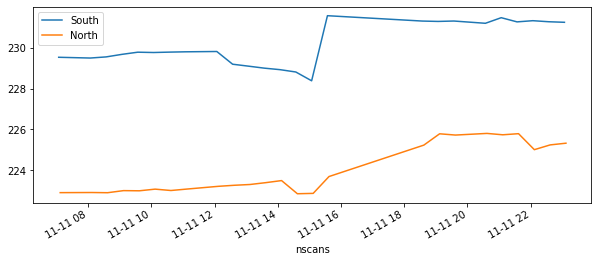

In [48]:

n = []
s = []

for hemisphere in range(2):
    sel = ds.isel(nscans = np.arange(hemisphere, len(ds.nscans), 2))
    alts = sel['tangent_point_altitude']       
    alts.mean(dim = ['nlats', 'nlons'], skipna = True).to_dataframe().plot(ax = ax)
    
ax.legend(['South', 'North'])

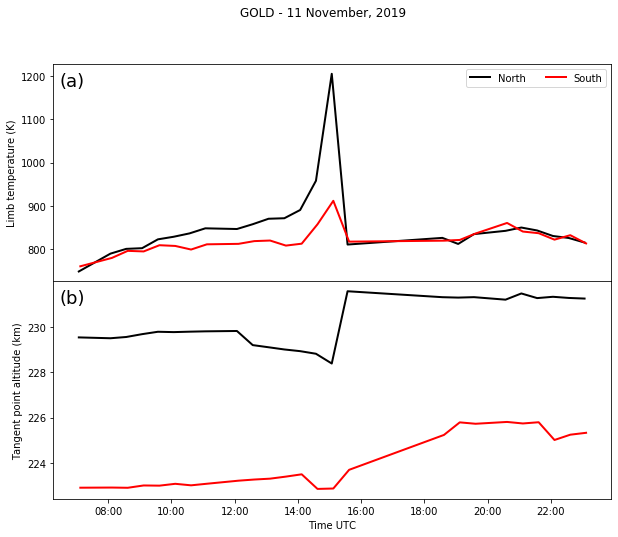

In [85]:
fig, ax = plt.subplots(figsize = (10, 8), nrows = 2, sharex = True)
plt.subplots_adjust(hspace = 0)
n = ds.isel(nscans = np.arange(0, len(ds.nscans), 2))
s = ds.isel(nscans = np.arange(1, len(ds.nscans), 2))

n['tangent_point_altitude'].mean(dim = ['nlats', 'nlons'], skipna = True).plot(label = 'North', ax = ax[1], color = 'black', lw = 2)
s['tangent_point_altitude'].mean(dim = ['nlats', 'nlons'], skipna = True).plot(label = 'South', ax = ax[1], color = 'red', lw = 2)

n['tlimb'].mean(dim = 'nlats', skipna = True).plot(label  = 'North', ax = ax[0], color = 'black', lw = 2)
s['tlimb'].mean(dim = 'nlats', skipna = True).plot(label = 'South', ax = ax[0], color = 'red', lw = 2)

ax[0].legend(loc = 'upper right', ncol = 2)

ax[1].set(xlabel = 'Time UTC', ylabel = 'Tangent point altitude (km)')
ax[0].set(ylabel = 'Limb temperature (K)', xlabel = '')

ax[1].text(0.01, 0.9, "(b)", fontsize = 18, transform = ax[1].transAxes)
ax[0].text(0.01, 0.9, "(a)", fontsize = 18, transform = ax[0].transAxes)


ax[1].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax[1].xaxis.set_major_locator(dates.HourLocator(interval = 2))

date_extent = split_filename(filename).date()
fig.suptitle(f'GOLD - {date_extent}')
plt.show()

In [90]:
s['tangent_point_altitude'].mean(dim = ['nlats', 'nlons'], skipna = True).max()

<xarray.DataArray 'tangent_point_altitude' ()>
array(225.80583191)

In [86]:

parameter = 'tlimb'
FigureName = figure_name(filename, parameter)

PathOut = 'C:\\Users\\Luiz Felipe\\Google Drive\\Doutorado\\Modelos_Latex_INPE\\Figuras1\\'

fig.savefig(PathOut + FigureName + '.png', dpi = 100, quality = 95, bbox_inches="tight")
FigureName 

'GOLD_TLIMB_L2_2019_11_11'